In [21]:
import numpy as np
import cv2
import skimage.io
import skimage.metrics as metrics
import pandas as pd

def gaussian_filter(size, sig_val):
    x = np.arange(-5, 6)
    y = np.arange(-5, 6)
    X, Y = np.meshgrid(x, y)
    Gf = np.exp(-((X**2) + (Y**2)) / (2 * (sig_val**2)))
    Gf /= np.sum(Gf)
    return Gf

def convolve_with_kernel(image, kernel):
    return cv2.filter2D(image, -1, kernel)

def compute_mse_ssim(sig_vals):
    image_names = [f"img{i}.bmp" for i in range(1, 6)]
    perfect_img = skimage.io.imread("perfect.bmp")

    data = []

    for image_path in image_names:
        img = skimage.io.imread(image_path)

        for sig_val in sig_vals:
            kernel = gaussian_filter(11, sig_val)
            b, g, r = cv2.split(img)

            blurred_image_r = convolve_with_kernel(r, kernel)
            blurred_image_g = convolve_with_kernel(g, kernel)
            blurred_image_b = convolve_with_kernel(b, kernel)

            denoised_img = cv2.merge([blurred_image_b, blurred_image_g, blurred_image_r])

            mse_value = metrics.mean_squared_error(denoised_img, perfect_img)
            ssim_value = metrics.structural_similarity(denoised_img, perfect_img, win_size=3, channel_axis=-1)

            data.append({"Image": image_path, "Sigma": sig_val, "MSE": mse_value, "SSIM": ssim_value})

    df = pd.DataFrame(data)

    print("\nMSE & SSIM Table:\n", df)

    return df

sigma_values = [0.1, 1, 2, 4, 8]
mse_ssim_table = compute_mse_ssim(sigma_values)



MSE & SSIM Table:
        Image  Sigma           MSE      SSIM
0   img1.bmp    0.1    919.071841  0.226207
1   img1.bmp    1.0    184.875726  0.613369
2   img1.bmp    2.0    252.372777  0.654034
3   img1.bmp    4.0    333.054353  0.626460
4   img1.bmp    8.0    364.793154  0.613220
5   img2.bmp    0.1     24.768181  0.834066
6   img2.bmp    1.0    108.550830  0.802469
7   img2.bmp    2.0    228.720007  0.679501
8   img2.bmp    4.0    319.259549  0.634000
9   img2.bmp    8.0    352.068997  0.622616
10  img3.bmp    0.1  15423.493832  0.009478
11  img3.bmp    1.0   2572.154717  0.127771
12  img3.bmp    2.0   1788.053307  0.402992
13  img3.bmp    4.0   1666.128221  0.507955
14  img3.bmp    8.0   1662.078923  0.485389
15  img4.bmp    0.1   1638.514123  0.158552
16  img4.bmp    1.0    248.236444  0.528211
17  img4.bmp    2.0    273.248363  0.634630
18  img4.bmp    4.0    345.524746  0.620264
19  img4.bmp    8.0    376.153261  0.605794
20  img5.bmp    0.1     79.697311  0.649100
21  img5.bmp

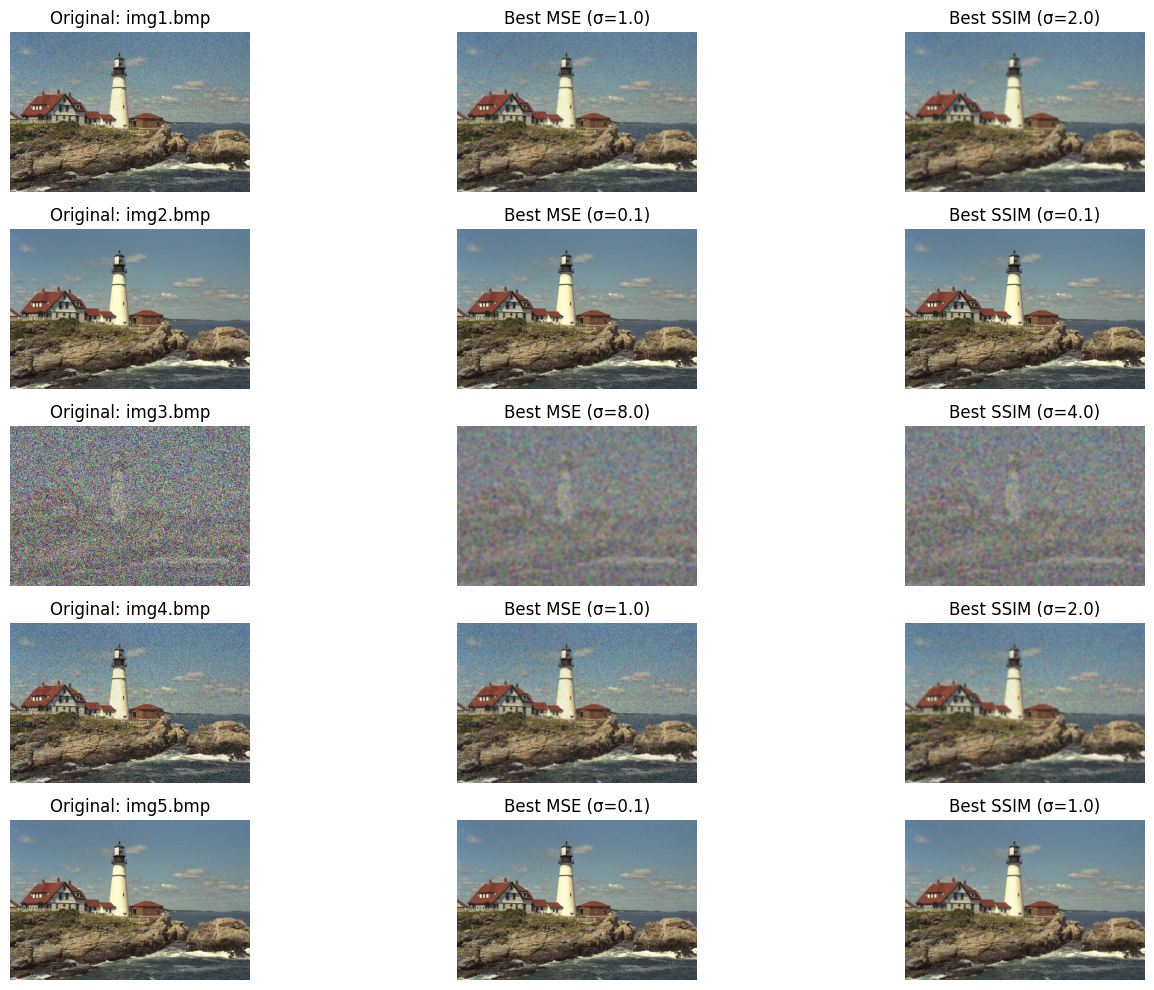

In [30]:
import matplotlib.pyplot as plt

def get_best_sigma(df):
    best_sigma = {}

    for img in df["Image"].unique():
        best_mse_sigma = df[df["Image"] == img].nsmallest(1, "MSE")["Sigma"].values[0]
        best_ssim_sigma = df[df["Image"] == img].nlargest(1, "SSIM")["Sigma"].values[0]
        best_sigma[img] = (best_mse_sigma, best_ssim_sigma)

    return best_sigma

def show_best_images(df):
    best_sigma = get_best_sigma(df)
    perfect_img = skimage.io.imread("perfect.bmp")

    plt.figure(figsize=(15, 10))

    for idx, (image_path, (sigma_mse, sigma_ssim)) in enumerate(best_sigma.items()):
        img = skimage.io.imread(image_path)

        kernel_mse = gaussian_filter(11, sigma_mse)
        kernel_ssim = gaussian_filter(11, sigma_ssim)

        b, g, r = cv2.split(img)
        denoised_mse = cv2.merge([
            convolve_with_kernel(b, kernel_mse),
            convolve_with_kernel(g, kernel_mse),
            convolve_with_kernel(r, kernel_mse),
        ])

        denoised_ssim = cv2.merge([
            convolve_with_kernel(b, kernel_ssim),
            convolve_with_kernel(g, kernel_ssim),
            convolve_with_kernel(r, kernel_ssim),
        ])

        plt.subplot(len(best_sigma), 3, 3 * idx + 1)
        plt.imshow(img)
        plt.title(f"Original: {image_path}")
        plt.axis("off")

        plt.subplot(len(best_sigma), 3, 3 * idx + 2)
        plt.imshow(denoised_mse)
        plt.title(f"Best MSE (σ={sigma_mse})")
        plt.axis("off")

        plt.subplot(len(best_sigma), 3, 3 * idx + 3)
        plt.imshow(denoised_ssim)
        plt.title(f"Best SSIM (σ={sigma_ssim})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_best_images(mse_ssim_table)


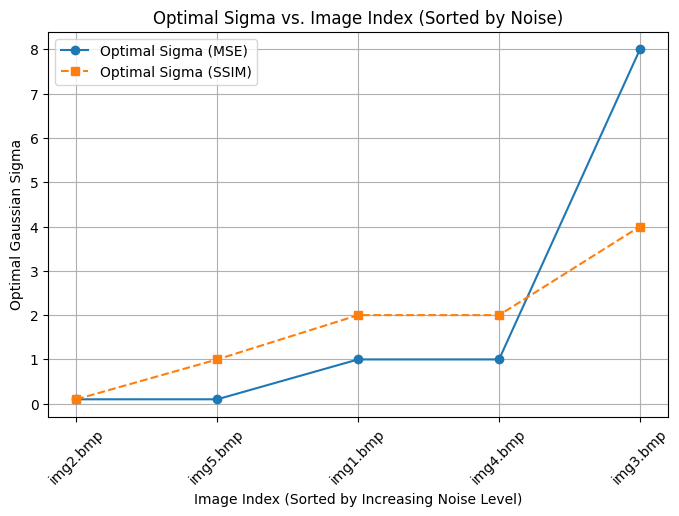


Comment:
As noise level increases, the optimal sigma also increases,
indicating that stronger smoothing is needed for noisier images.


In [32]:
def plot_optimal_sigma(df):
    best_sigma = get_best_sigma(df)

    sorted_images = sorted(best_sigma.keys(), key=lambda img: df[df["Image"] == img]["MSE"].min())

    indices = range(1, len(sorted_images) + 1)

    sigma_mse = [best_sigma[img][0] for img in sorted_images]
    sigma_ssim = [best_sigma[img][1] for img in sorted_images]

    plt.figure(figsize=(8, 5))
    plt.plot(indices, sigma_mse, marker='o', linestyle='-', label="Optimal Sigma (MSE)")
    plt.plot(indices, sigma_ssim, marker='s', linestyle='--', label="Optimal Sigma (SSIM)")

    plt.xlabel("Image Index (Sorted by Increasing Noise Level)")
    plt.ylabel("Optimal Gaussian Sigma")
    plt.title("Optimal Sigma vs. Image Index (Sorted by Noise)")
    plt.xticks(indices, sorted_images, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\nComment:")
    print("As noise level increases, the optimal sigma also increases,")
    print("indicating that stronger smoothing is needed for noisier images.")

plot_optimal_sigma(mse_ssim_table)
